In [125]:
import pandas as pd
import re
import os
import numpy as np
import glob
from datetime import datetime
import geopandas as gpd
import json
from shapely.geometry import shape, GeometryCollection
from rasterio.plot import show
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

import shutil
import rasterio

%matplotlib inline

In [126]:
json_folder = r"C:\Users\yc463\Documents\JamesLocal\DS\Drone\GEOJSONDATA\GeoJson"
img_folder = r'C:\Users\yc463\Documents\JamesLocal\DS\Drone\GEOJSONDATA\Naver'
tiff_folder = r'C:\Users\yc463\Documents\JamesLocal\DS\Drone\GEOJSONDATA\GeoTiff'

In [127]:
files = glob.glob(os.path.join(tiff_folder,'*.tif'))
files

['C:\\Users\\yc463\\Documents\\JamesLocal\\DS\\Drone\\GEOJSONDATA\\GeoTiff\\아세코밸리골프클럽L14.tif',
 'C:\\Users\\yc463\\Documents\\JamesLocal\\DS\\Drone\\GEOJSONDATA\\GeoTiff\\아세코밸리골프클럽L15.tif',
 'C:\\Users\\yc463\\Documents\\JamesLocal\\DS\\Drone\\GEOJSONDATA\\GeoTiff\\아세코밸리골프클럽L18.tif',
 'C:\\Users\\yc463\\Documents\\JamesLocal\\DS\\Drone\\GEOJSONDATA\\GeoTiff\\오너스GCL14.tif',
 'C:\\Users\\yc463\\Documents\\JamesLocal\\DS\\Drone\\GEOJSONDATA\\GeoTiff\\오너스GCL15.tif',
 'C:\\Users\\yc463\\Documents\\JamesLocal\\DS\\Drone\\GEOJSONDATA\\GeoTiff\\오너스GCL18.tif',
 'C:\\Users\\yc463\\Documents\\JamesLocal\\DS\\Drone\\GEOJSONDATA\\GeoTiff\\중문골프클럽L14.tif',
 'C:\\Users\\yc463\\Documents\\JamesLocal\\DS\\Drone\\GEOJSONDATA\\GeoTiff\\중문골프클럽L15.tif',
 'C:\\Users\\yc463\\Documents\\JamesLocal\\DS\\Drone\\GEOJSONDATA\\GeoTiff\\중문골프클럽L18.tif',
 'C:\\Users\\yc463\\Documents\\JamesLocal\\DS\\Drone\\GEOJSONDATA\\GeoTiff\\클럽디거창CCL14.tif',
 'C:\\Users\\yc463\\Documents\\JamesLocal\\DS\\Drone\\GEOJSONDATA\\GeoTif

In [128]:
target_courseName = '오너스'

In [129]:
out_tiff = [ x for x in files if 'L18' in x and target_courseName in x][0]

#### 이미지를 읽어온다 Raterio활용. 

In [130]:
import rasterio
import cv2

with rasterio.open(out_tiff, mode='r+') as dataset:
  image_org = dataset.read()
  image_org = image_org.transpose(1, 2, 0) # RGB

In [131]:
dataset.crs

CRS.from_wkt('GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]')

### Color Quantization with OpenCV

In [132]:
from sklearn.cluster import MiniBatchKMeans

# Convert RGB to BGR
image_bgr = cv2.cvtColor(image_org, cv2.COLOR_RGB2BGR)
(h, w) = image_bgr.shape[:2]
# convert the image from the RGB color space to the L*a*b*
# color space -- since we will be clustering using k-means
# which is based on the euclidean distance, we'll use the
# L*a*b* color space where the euclidean distance implies
# perceptual meaning
image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2LAB)
# reshape the image into a feature vector so that k-means
# can be applied
image = image.reshape((image.shape[0] * image.shape[1], 3))
# apply k-means using the specified number of clusters and
# then create the quantized image based on the predictions
clt = MiniBatchKMeans(n_clusters = 10)
labels = clt.fit_predict(image)
quant = clt.cluster_centers_.astype("uint8")[labels]
# reshape the feature vectors to images
quant = quant.reshape((h, w, 3))
image = image.reshape((h, w, 3))
# convert from L*a*b* to RGB
quant = cv2.cvtColor(quant, cv2.COLOR_LAB2BGR)
image = cv2.cvtColor(image, cv2.COLOR_LAB2BGR)

c:\anaconda3\envs\geo_James\lib\site-packages\sklearn\cluster\_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
c:\anaconda3\envs\geo_James\lib\site-packages\sklearn\cluster\_kmeans.py:1966: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


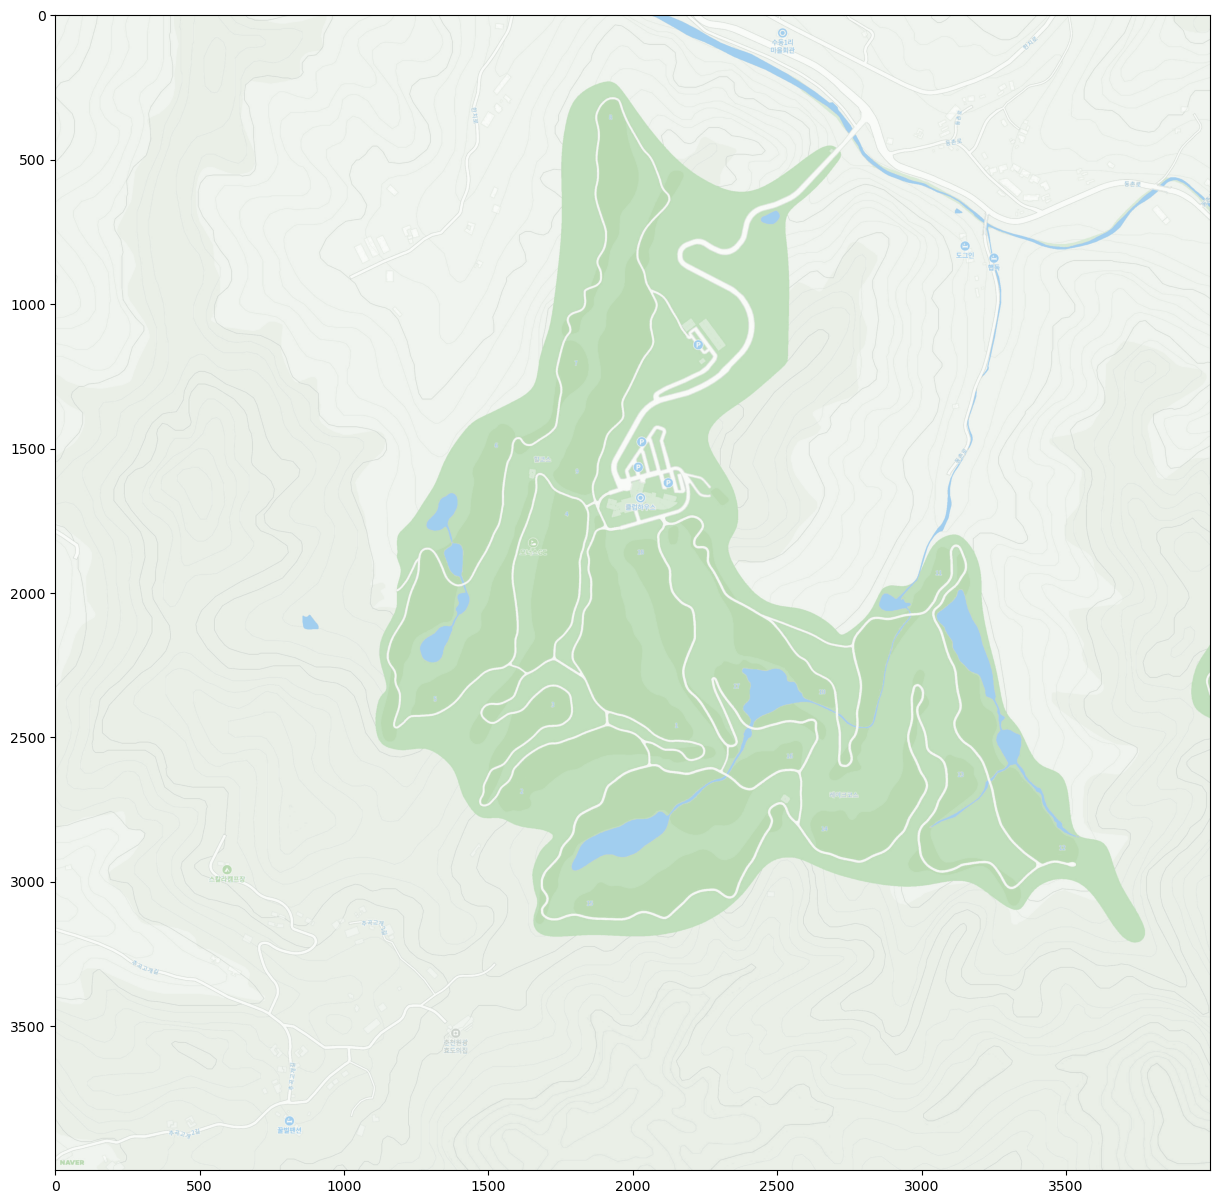

In [133]:
fig, ax = plt.subplots(figsize=(15,15))
plt.imshow(cv2.cvtColor(quant, cv2.COLOR_BGR2RGB))

In [134]:
image = quant.copy()

In [135]:
## Convert to HSV
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

## Mask of green (36,25,25) ~ (86, 255,255)
# mask = cv2.inRange(hsv, (36, 25, 25), (86, 255,255))
# 65,  41, 223
#  67,  48, 218
#  68,  38, 206]
# mask = cv2.inRange(hsv, (57, 38, 73), (80, 55,217)) # green
mask = cv2.inRange(hsv, (54, 35, 70), (80, 55,219))
# mask = cv2.inRange(hsv, (24, 29, 217), (76, 77,221))
# (hMin = 65 , sMin = 34, vMin = 126), (hMax = 69 , sMax = 90, vMax = 227)
# (hMin = 64 , sMin = 30, vMin = 191), (hMax = 71 , sMax = 49, vMax = 233)
# mask = cv2.inRange(hsv, (65,30,151), (68, 101,255))
# (hMin = 43 , sMin = 41, vMin = 98), (hMax = 71 , sMax = 115, vMax = 218) for 거창
# mask = cv2.inRange(hsv, (63,41,151), (68, 51,255))
image2 = cv2.bitwise_and(image, image, mask = mask)

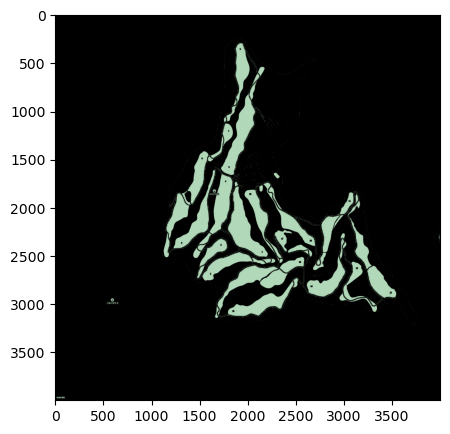

In [136]:
plt.figure(figsize=(5,5))
plt.imshow(image2)
plt.axis('on')
plt.show()

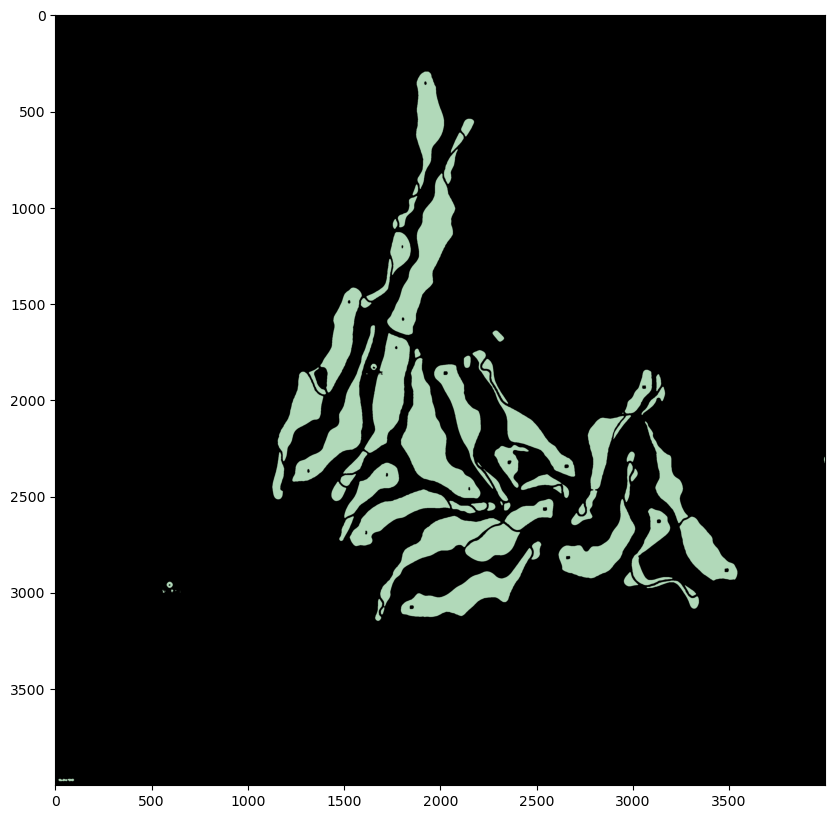

In [137]:
im1_blurred = cv2.medianBlur(image2 ,11)

fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(im1_blurred)

In [138]:
import numpy as np 

pixel_values = im1_blurred.reshape((-1, 3))
pixel_values = np.float32(pixel_values)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
k = 2
_, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# convert back to 8 bit values
centers = np.uint8(centers)

# flatten the labels array
labels = labels.flatten()

# convert all pixels to the color of the centroids
segmented_image = centers[labels.flatten()]

# reshape back to the original image dimension
segmented_image = segmented_image.reshape(im1_blurred.shape)

mask = labels.reshape(im1_blurred.shape[:2]).astype(np.uint8)

if np.where(centers == [0,0,0])[0][0] == 1:
  mask = np.logical_not(mask).astype(np.uint8)

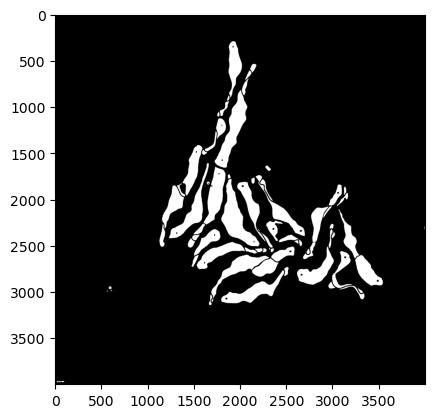

In [139]:
plt.imshow(mask, cmap = 'gray')

In [140]:
contours, hierarchy = cv2.findContours(image=mask.astype(np.uint8), mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)

In [141]:
len(contours)

81

In [152]:
approx_contours = []
approx_cnt_center = []

for c in contours:
    epsilon = 0.004*cv2.arcLength(c,True)
    approx = cv2.approxPolyDP(c,epsilon,True)

    M = cv2.moments(approx)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    
    if cv2.contourArea(c) > 5000:
        approx_contours.append(approx)
        approx_cnt_center.append([cX,cY])
    print(c.shape,approx.shape)

(23, 1, 2) (23, 1, 2)
(20, 1, 2) (20, 1, 2)
(19, 1, 2) (19, 1, 2)
(18, 1, 2) (18, 1, 2)
(22, 1, 2) (22, 1, 2)
(21, 1, 2) (21, 1, 2)
(17, 1, 2) (17, 1, 2)
(18, 1, 2) (18, 1, 2)
(21, 1, 2) (21, 1, 2)
(16, 1, 2) (16, 1, 2)
(18, 1, 2) (18, 1, 2)
(17, 1, 2) (17, 1, 2)
(12, 1, 2) (12, 1, 2)
(26, 1, 2) (26, 1, 2)
(20, 1, 2) (20, 1, 2)
(23, 1, 2) (23, 1, 2)
(21, 1, 2) (21, 1, 2)
(21, 1, 2) (21, 1, 2)
(21, 1, 2) (21, 1, 2)
(23, 1, 2) (23, 1, 2)
(20, 1, 2) (20, 1, 2)
(18, 1, 2) (18, 1, 2)
(18, 1, 2) (18, 1, 2)
(20, 1, 2) (20, 1, 2)
(14, 1, 2) (14, 1, 2)
(17, 1, 2) (17, 1, 2)
(19, 1, 2) (19, 1, 2)
(17, 1, 2) (17, 1, 2)
(19, 1, 2) (19, 1, 2)


In [153]:
len(approx_contours)

28

In [154]:
approx_cnt_center

[[3261, 3008],
 [2135, 3006],
 [2274, 2745],
 [3377, 2788],
 [1993, 2743],
 [3098, 2744],
 [2826, 2784],
 [2466, 2592],
 [1763, 2590],
 [2522, 2426],
 [1655, 2445],
 [1160, 2413],
 [1564, 2332],
 [2358, 2317],
 [3185, 2424],
 [2822, 2299],
 [1276, 2059],
 [3040, 1961],
 [2108, 2039],
 [1955, 2217],
 [2466, 2166],
 [1736, 1951],
 [1478, 2144],
 [1489, 1671],
 [1697, 1408],
 [1791, 1223],
 [1922, 1260],
 [1936, 545]]

In [179]:
image_copy = image_org.copy()
# c = max(contours, key = cv2.contourArea)

for in_, c in enumerate(approx_contours):
  # print(approx_cnt_center[in_][0])
  image_copy = cv2.drawContours(image=image_copy, contours=[c], contourIdx=-1, color=(255,1,1), thickness=2, lineType=cv2.LINE_AA)
  image_copy = cv2.putText(image_copy, str(in_), (approx_cnt_center[in_][0] - 20, approx_cnt_center[in_][1] - 20),cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 0), 2)

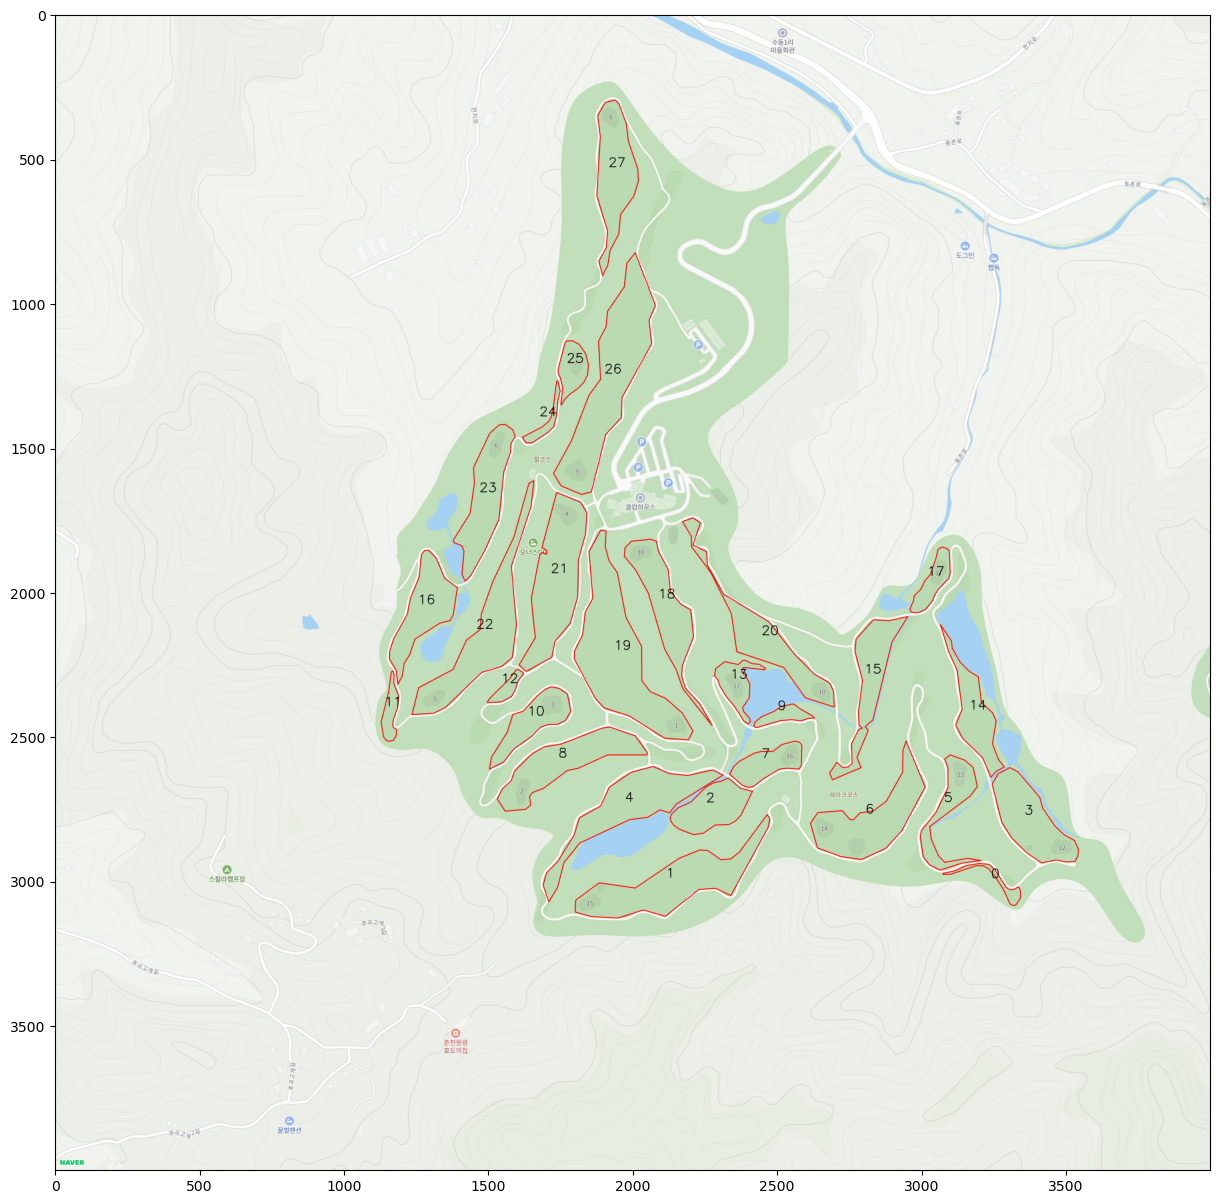

In [180]:
fig, ax = plt.subplots(figsize=(15, 15))
plt.imshow(image_copy)

In [146]:
contours = approx_contours

def convert_latlon(a,dataset_):
    return dataset_.xy(a[1],a[0])

In [147]:
from shapely.geometry import Polygon


con_geo = []
for i,contour in enumerate(contours):
    con_single = np.squeeze(np.apply_along_axis(lambda p: convert_latlon(p, dataset), -1, contour))
    
    try:
        con_single = Polygon(con_single)
        con_geo.append(con_single)
    except:
        pass

In [148]:
gdf = gpd.GeoSeries(con_geo, crs=int(4326))
gdf = gpd.GeoDataFrame(geometry=gdf)
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [149]:
gdf['Name']= 'Contour_' + gdf.index.astype(str)
gdf['Client'] = os.path.split(out_tiff)[-1].split('L')[0]

gdf['Course'] = 'TBD'
gdf['Hole'] = gdf.index.astype(str)

gdf['Type'] = '홀영역'
gdf['Valid'] = True




In [150]:
gdf

,geometry,Name,Client,Course,Hole,Type,Valid
0,"POLYGON ((127.66190 37.76631, 127.66192 37.766...",Contour_0,오너스GC,TBD,0,홀영역,True
1,"POLYGON ((127.65869 37.76711, 127.65864 37.767...",Contour_1,오너스GC,TBD,1,홀영역,True
2,"POLYGON ((127.65837 37.76751, 127.65814 37.767...",Contour_2,오너스GC,TBD,2,홀영역,True
3,"POLYGON ((127.66293 37.76777, 127.66282 37.767...",Contour_3,오너스GC,TBD,3,홀영역,True
4,"POLYGON ((127.65782 37.76775, 127.65763 37.767...",Contour_4,오너스GC,TBD,4,홀영역,True
5,"POLYGON ((127.66204 37.76805, 127.66194 37.767...",Contour_5,오너스GC,TBD,5,홀영역,True
6,"POLYGON ((127.66122 37.76825, 127.66116 37.768...",Contour_6,오너스GC,TBD,6,홀영역,True
7,"POLYGON ((127.65929 37.76819, 127.65924 37.768...",Contour_7,오너스GC,TBD,7,홀영역,True
8,"POLYGON ((127.65642 37.76807, 127.65619 37.768...",Contour_8,오너스GC,TBD,8,홀영역,True
9,"POLYGON ((127.65952 37.76859, 127.65948 37.768...",Contour_9,오너스GC,TBD,9,홀영역,True


In [151]:
import fiona
with fiona.Env(OSR_WKT_FORMAT="WKT2_2018"):
  gdf.to_file(os.path.join(json_folder,os.path.split(out_tiff)[-1].split('L')[0]+'_홀영역_'+'.geojson'), driver='GeoJSON')